In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
import os
import random
import csv
import json
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.feature_selection import RFE
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from urllib.request import urlopen
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import lightgbm as lgb
import statsmodels.tsa.stattools as ts
from lib import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))
# fill out missing data
df_jhu.at['02158', 'Area in square miles - Land area'] = 19673
df_jhu.at['02158', 'Density per square mile of land area - Population'] = 0.44
df_jhu.at['46102', 'Area in square miles - Land area'] = 2097
df_jhu.at['46102', 'Density per square mile of land area - Population'] = 6.5

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
repo = git.Repo("./", search_parent_directories=True)
home_dir = repo.working_dir
county_centers = pd.read_csv(home_dir+'/data/us/geolocation/county_centers.csv')
objective_df = pd.read_csv(home_dir +'/data/us/covid/nyt_us_counties_daily.csv') # Use the non-cumulative results
county_centers = county_centers[['pclon10', 'pclat10', 'fips']]
county_centers.head()

,pclon10,pclat10,fips
0,-86.494165,32.500389,1001
1,-87.762381,30.548923,1003
2,-85.310038,31.844036,1005
3,-87.127659,33.030921,1007
4,-86.591491,33.955243,1009


In [3]:
df_jhu_merged = df_jhu.merge(county_centers, how = 'left', on='fips')
print(df_jhu.shape)
df_jhu_merged['FIPS'] = df_jhu_merged['fips']
df_jhu_merged = df_jhu_merged.set_index('FIPS')
df_jhu_merged_states = df_jhu_merged[df_jhu_merged.fips % 1000 != 0]
df_jhu_merged_states.head()

(3272, 334)


,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,NATURAL_INC_2018,...,Radiology specialists (2019),Cardiology specialists (2019),Oncology (Cancer) specialists (2019),Endocrinology Diabetes and Metabolism specialists (2019),All Other Specialties specialists (2019),Total Specialist Physicians (2019),transit_scores - population weighted averages aggregated from town/city level to county,fips,pclon10,pclat10
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,AL,Autauga County,2.0,2.0,0.0,55601,158.0,655.0,532.0,123.0,...,7.666952,4.663873,2.741447,0.807646,29.791911,72.142154,0.0,1001,-86.494165,32.500389
1003,AL,Baldwin County,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,26.0,...,30.063565,18.287925,10.749732,3.166933,116.819699,282.882982,368329051.0,1003,-87.762381,30.548923
1005,AL,Barbour County,6.0,6.0,3.0,24881,-277.0,261.0,324.0,-63.0,...,3.430899,2.087046,1.226776,0.361415,13.331641,32.283033,0.0,1005,-85.310038,31.844036
1007,AL,Bibb County,1.0,1.0,0.0,22400,-155.0,250.0,256.0,-6.0,...,3.088789,1.878937,1.104448,0.325377,12.002281,29.063942,158361697.0,1007,-87.127659,33.030921
1009,AL,Blount County,1.0,1.0,0.0,57840,13.0,681.0,662.0,19.0,...,7.975693,4.851683,2.851843,0.840169,30.991603,75.047251,0.0,1009,-86.591491,33.955243


In [4]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips','pclon10', 'pclat10']

In [5]:
cum_death_counter = CumDeathCounter()
cum_case_counter = CumCaseCounter()
delta_death_counter = DeltaCounter(cum_death_counter)
delta_case_counter = DeltaCounter(cum_case_counter)
delta_death_ratio_counter = RatioCounter(delta_death_counter)
delta_case_ratio_counter = RatioCounter(delta_case_counter)

In [6]:
mobility_counter = MobilityCounter()

/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/exploratory/Sean's Notebook/lib.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  counties['fips'] = counties['fips'].map(lambda f: int(f))


/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/exploratory/Sean's Notebook/lib.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  county_data['date'] = county_data['date'].map(lambda l: (get_date(l) - get_date('2020-01-01')).days)


In [7]:
def split_fips(counter, min_thresh=10):
    fips_list = get_fips()
    large_fips = []
    small_fips = []
    for fips in fips_list:
        X,y = counter.getY(fips)
        if y[-1] > min_thresh:
            large_fips.append(fips)
        else:
            small_fips.append(fips)
    return large_fips, small_fips
df_jhu_states = df_jhu[df_jhu.fips % 1000 == 0]
 
def state_to_fip(state_abr):
    # Converts state abbreviation to FIPS code
    return df_jhu_states.fips[df_jhu_states.State == state_abr].values[0]

In [234]:
def get_XY(df, features, delta_y, look_back_y, y_generator, fips_list=get_fips(), moving_window=True):
    df = df[features]
    df = df[df.fips % 1000 != 0] # remove aggregate states
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    
    df['mobility'] = df['fips'].map(lambda fip: 0)
    df['cases'] = df['fips'].map(lambda fip: 0)
    
    col_names = []
    for i in range(look_back_y):
        if i == 0:
            col_name = "deaths"
        else:
            col_name = "deaths %d days ago" %i
        col_names.append(col_name)
        df[col_name] = df['fips'].map(lambda fip: 0)
    X = []
    Y = []
    for fips in df.index:
        if int(fips) not in fips_list:
            continue
        base = df.loc[fips].values
        _, cum_cases = cum_case_counter.getY(int(fips))
        try:
            t, ys = y_generator.getY(int(fips))
        except KeyError:
            continue
        if len(ys) == 0:
            X.append(base)
            Y.append(0)
            continue
        for j in range(-1, -len(ys), -1):
            base = df.loc[fips].values
            if j - delta_y >= -len(cum_cases):
                base[-look_back_y - 1] = cum_cases[j - delta_y]
            Y.append(ys[j])
            try:
                time = t[j-delta_y]
                base[-look_back_y - 2] = mobility_counter.getYByDay(int(fips), time)
            except:
                pass
            for i in range(look_back_y):
                if j - delta_y - i >= -len(ys):
                    base[-look_back_y + i] = ys[j - delta_y - i]
            X.append(base)
            if not moving_window:
                break
    df_new = pd.DataFrame(X, columns = df.columns)
    df_new['target'] = Y
    return df_new

def get_XY_with_neighs(df, features, delta_y, look_back_y, y_generator, fips_list=get_fips(), moving_window=True):
    df_new = get_XY(df, features, delta_y, look_back_y, y_generator, fips_list=fips_list, moving_window=moving_window)
    df_new = df_new.loc[~np.isnan(df_new.pclon10)]
    X = df_new.iloc[:,2:-1]
    y = df_new['target'].values
    X = add_radius_neighbors(add_neighbors(X))
    return X, y

def Rsquare(pred, actual):   
    return np.corrcoef(pred, actual)[0,1]**2

## Splitting

In [253]:
large_fips, small_fips = split_fips(cum_death_counter,min_thresh=10)

In [334]:
X,y = get_XY_with_neighs(df_jhu_merged, features, 1, 5, delta_death_counter, fips_list=large_fips, moving_window=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Ordinary Least Squares
R^2 (in sample): 0.851798
R^2 (out sample): 0.814581
Ridge Model
R^2 (in sample): 0.850582
R^2 (out sample): 0.820889
Lasso Model
R^2 (in sample): 0.803114
R^2 (out sample): 0.803391


/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1578.7331015607194, tolerance: 1.481079863481229
  positive)


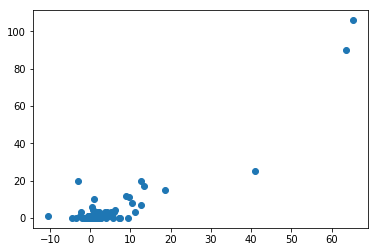

In [335]:
normal_model = LinearRegression().fit(X_train.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model.score(X_train,y_train))
print("R^2 (out sample): %f" % normal_model.score(X_test,y_test))
ridge_model = Ridge(alpha=15)
ridge_model.fit(X_train.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model.score(X_train,y_train))
print("R^2 (out sample): %f" % ridge_model.score(X_test,y_test))
lasso_model = Lasso(alpha=5)
lasso_model.fit(X_train.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model.score(X_train,y_train))
print("R^2 (out sample): %f" % lasso_model.score(X_test,y_test))
plt.scatter(lasso_model.predict(X_test), y_test)

Optimum number of features: 35
Score with 35 features: 0.819104


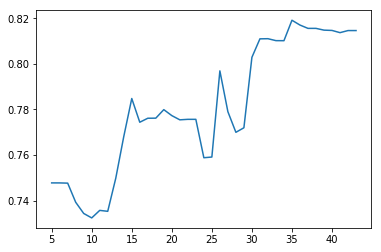

In [336]:
nof_list=np.arange(5,44)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
plt.plot(nof_list, score_list)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [337]:
model = LinearRegression()
rfe = RFE(model,12)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe,y_train)
print(model.score(X_test_rfe,y_test))
support = rfe.support_

0.7353424612151831


In [338]:
good_cols = []
for i in range(len(support)):
    if support[i]:
        good_cols.append(X_train.columns[i])
good_cols

['Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Non-profit hospital beds per 1000 people (2019)',
 'Total hospital beds per 1000 people (2019)',
 'deaths',
 'deaths 1 days ago',
 'deaths 2 days ago',
 'dist_0',
 'dist_1',
 'dist_2',
 'dist_3',
 'dist_4',
 'num_in_radius']

In [339]:
X_test_filtered = X_test[good_cols]
X_train_filtered = X_train[good_cols]

Ordinary Least Squares
R^2 (in sample): 0.754068
R^2 (out sample): 0.735342
Ridge Model
R^2 (in sample): 0.753971
R^2 (out sample): 0.734716
Lasso Model
R^2 (in sample): 0.733093
R^2 (out sample): 0.740072


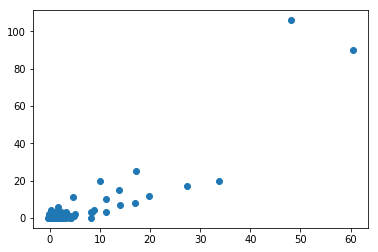

In [340]:
normal_model = LinearRegression().fit(X_train_filtered.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % normal_model.score(X_test_filtered,y_test))
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_filtered.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % ridge_model.score(X_test_filtered,y_test))
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train_filtered.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % lasso_model.score(X_test_filtered,y_test))
plt.scatter(lasso_model.predict(X_test_filtered), y_test)

In [365]:
n, d = X_train_filtered.shape
X_train_filtered['intercept'] = np.ones(n)
n1, d = X_test_filtered.shape
X_test_filtered['intercept'] = np.ones(n1)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


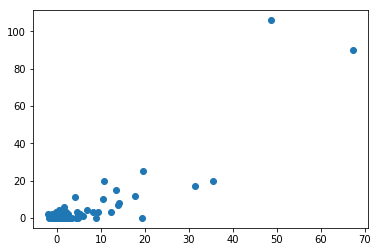

In [366]:
model = sm.OLS(y_train,X_train_filtered)
result = model.fit()
plt.scatter(result.predict(X_test_filtered), y_test)

# Submission 2

In [277]:
# Get a list of OLS trained models
def train_models(fips_set, good_cols, min_look_ahead=1, max_look_ahead=14):
    models = []
    for delta_y in range(min_look_ahead, max_look_ahead + 1):
        X,y = get_XY_with_neighs(df_jhu_merged, features, 1, 5, delta_death_counter, fips_list=large_fips, moving_window=False)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        X_test = X_test[good_cols]
        X_train = X_train[good_cols]
        model = sm.OLS(y_train,X_train)
        print("Training model to predict %d days in the future" % delta_y)
        result = model.fit()
        print("R squared (out sample) is %f" % (Rsquare(result.predict(X_test), y_test)))
        models.append(result)
    return  models

In [278]:
model_list = train_models(large_fips, good_cols)

Training model to predict 1 days in the future
R squared (out sample) is 0.709561
Training model to predict 2 days in the future
R squared (out sample) is 0.733765
Training model to predict 3 days in the future
R squared (out sample) is 0.773788
Training model to predict 4 days in the future
R squared (out sample) is 0.657246
Training model to predict 5 days in the future
R squared (out sample) is 0.645630
Training model to predict 6 days in the future
R squared (out sample) is 0.922108
Training model to predict 7 days in the future
R squared (out sample) is 0.740242
Training model to predict 8 days in the future
R squared (out sample) is 0.781707
Training model to predict 9 days in the future
R squared (out sample) is 0.862900
Training model to predict 10 days in the future
R squared (out sample) is 0.788220
Training model to predict 11 days in the future
R squared (out sample) is 0.723380
Training model to predict 12 days in the future
R squared (out sample) is 0.583652
Training mode

In [279]:
def get_param_info(models, min_look_ahead=1, max_look_ahead=14):
    params_mu = {}
    params_stderr = {}
    for i in range(len(models)):
        model = models[i]
        params_mu[i + min_look_ahead] = model.params
        params_stderr[i + min_look_ahead] = model.bse
    return params_mu, params_stderr

In [280]:
param_mu, param_stderr = get_param_info(model_list)

In [291]:
df_true,_ =get_XY_with_neighs(df_jhu_merged, features, 0, 5, delta_death_counter, fips_list=large_fips, moving_window=False)
X_true = df_true[good_cols]
X_true.head()

,Active General Surgeons per 100000 Population 2018 (AAMC),Non-profit hospital beds per 1000 people (2019),Unemployment_rate_2018,Total hospital beds per 1000 people (2019),deaths,deaths 1 days ago,deaths 2 days ago,deaths 4 days ago,dist_1,dist_2,dist_3,dist_4
0,7.6,0.8,3.9,3.1,0,0,0,2,0.598075,0.793388,0.943265,1.014976
1,7.6,0.8,3.7,3.1,0,0,2,3,1.160085,1.682303,1.732000,1.738788
2,7.6,0.8,3.6,3.1,0,0,0,3,0.582432,1.015178,1.070217,1.077062
3,7.6,0.8,4.7,3.1,1,0,6,7,1.280197,1.461697,1.794051,1.802942
4,7.6,0.8,2.9,3.1,0,0,1,1,0.976987,1.533123,1.559408,1.725444


In [282]:
def gen_percentiles(X, param_mu, param_stderr, fips_list, min_look_ahead=1, max_look_ahead=14):
    output = {}
    for i in range(min_look_ahead, max_look_ahead + 1):
        n_samples = 400
        fips_to_samples = {}
        fips_to_percentiles = {}
        for fips in fips_list:
            fips_to_samples[fips] = []
            fips_to_percentiles[fips] = {}
        for j in range(n_samples):
            param_sample = np.random.normal(param_mu[i], param_stderr[i])
            res = np.matmul(X.values, param_sample)
            for k in range(len(fips_list)):
                fips_to_samples[fips_list[k]].append(res[k])
        for fips in fips_list:
            for percentile in range(10, 100, 10):
                fips_to_percentiles[fips][percentile] = np.percentile(fips_to_samples[fips], percentile, axis=0)
        output[i] = fips_to_percentiles
    return output
percentiles = gen_percentiles(X_true, param_mu, param_stderr, large_fips, 1, 14)

In [382]:
df_sample_sub = pd.read_csv(f"{homedir}/sample_submission.csv")
df_sample_sub['fips'] = df_sample_sub['id'].map(lambda i : int(i[11:]))
output_fips = df_sample_sub.fips.unique()

In [389]:
import datetime
def truncate(dec):
    return int(100*dec)/100
with open('submission.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

    today = datetime.date.today();   
    for i in range(-34, 0):
        target_day = today + datetime.timedelta(days=i)
        string_pre = target_day.strftime('%Y-%m-%d-')
        for fips in output_fips:
            print_lst = [string_pre + str(fips)]
            try:
                X, y = delta_death_counter.getY(fips)
                for j in range(9):
                    print_lst.append(y[i])
            except:
                for j in range(9):
                    print_lst.append(0)
            writer.writerow(print_lst)
    for delta_y in range(1, 58):
        target_day = today + datetime.timedelta(days=delta_y-1)
        string_pre = target_day.strftime('%Y-%m-%d-')
        if delta_y > 14:
            for fips in output_fips:
                l = [string_pre + str(fips)]
                writer.writerow(l + [0] * 9)
            continue
        for fips in output_fips:
            print_lst = [string_pre + str(fips)]
            if fips in percentiles[delta_y].keys():
                for percentile in range(10,100,10):
                    datum = percentiles[delta_y][fips][percentile]
                    if datum < 0:
                        datum = 0
                    print_lst.append(truncate(datum))
            else:
                for i in range(9):
                    print_lst.append(0)
            writer.writerow(print_lst)

In [390]:
your_submission = pd.read_csv('submission.csv').set_index('id').sort_index()
sample_submission = pd.read_csv(f"{homedir}/sample_submission.csv").set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))